In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime, MTMultipleDates
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()


training = False
save_probabilities = True
loadInference = True
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		exp = 70 # train 2017-2018
		
		
		# exp = 39 # train 2018-2019. test 2018-2019
		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		

else:
	exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 75

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
exp

70

In [5]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [6]:
# ic(type(dataset), exp, dataset.dates)


In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0, 1], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| self.paths.labelFromProject: 'D:/Jorge/datasets/deforestation/Para_2018_2019/mask_label_17730x9203.npy'
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [8]:
# np.save('label_not_independent.npy', label_mask)


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:
label_mask.dtype

dtype('uint8')

In [11]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [14]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [15]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [16]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [17]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [18]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

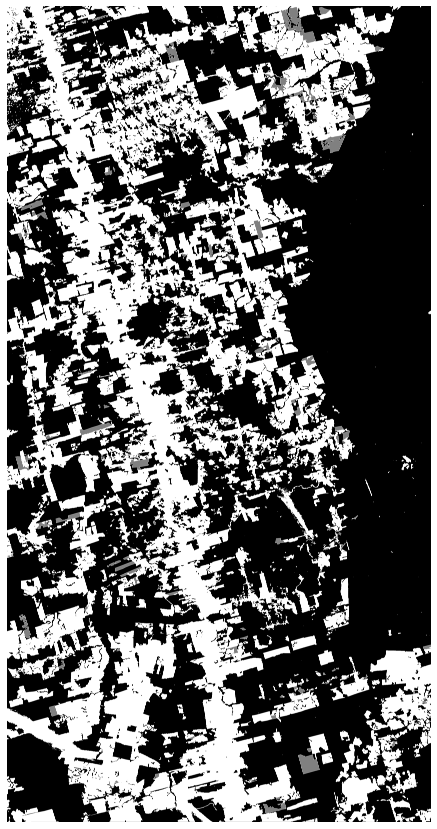

In [19]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [20]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [21]:
if training == True:
    print(coords_train)

In [22]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [23]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [24]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [25]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [26]:
if training == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [27]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [28]:
if training == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [29]:
if training == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [30]:
if training == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [31]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [32]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [33]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [34]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [35]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp70'

In [36]:
channels

21

In [37]:
image_stack.shape

(17730, 9200, 21)

In [38]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [39]:
image_stack.shape

(17730, 9200, 21)

In [40]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [41]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [42]:
image_stack.shape

(17730, 9200, 21)

In [43]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [44]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp70/models/resunet_0.h5'


In [45]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [46]:
del image1_pad


In [47]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [48]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [49]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

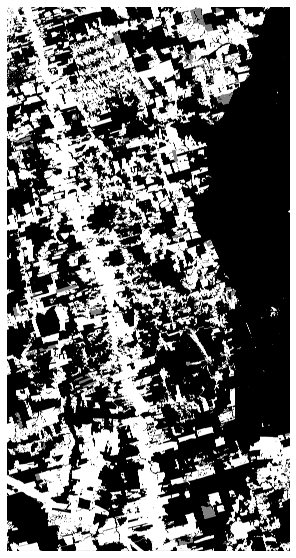

In [50]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [51]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

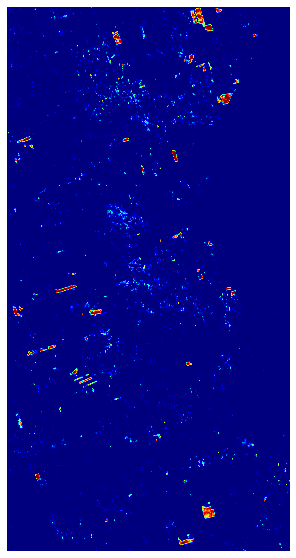

In [52]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [53]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [54]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54253101,)
(array([0, 1], dtype=uint8), array([53486282,   766819], dtype=int64))


In [55]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

85.67


In [56]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [57]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [58]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [60]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 3.0951157e-38
    np.mean(prob_rec): 0.0133172935
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [61]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [62]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.011016262
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 4.1009997e-27
    np.mean(pred_entropy): 0.01212915
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [63]:
prob_rec.shape

(10, 17760, 9216, 1)

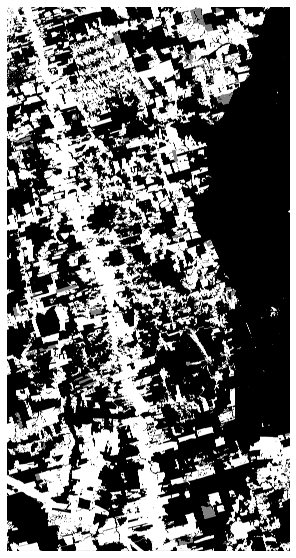

In [64]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [65]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

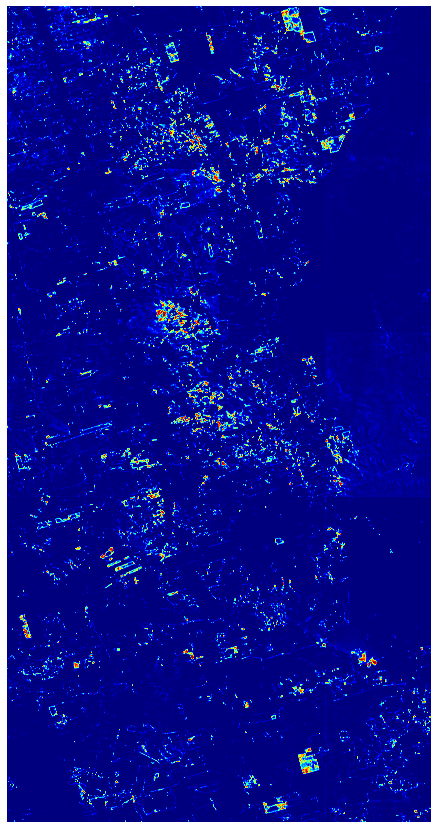

In [66]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [67]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

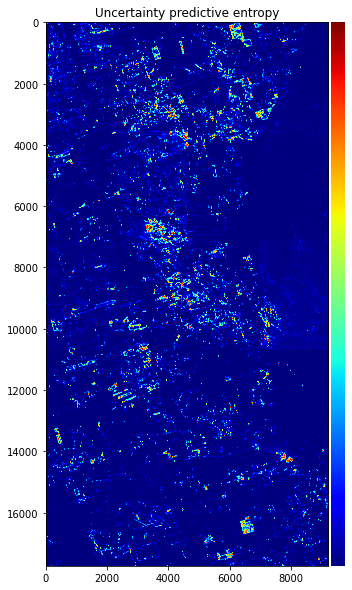

In [68]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [69]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 3.0951157e-38
    np.mean(prob_rec): 0.0133172935
    np.max(prob_rec): 1.0


(3.0951157e-38, 0.0133172935, 1.0)

In [70]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [71]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


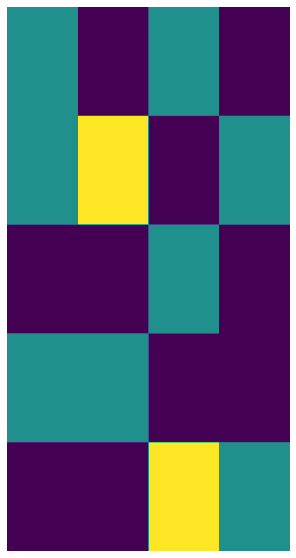

In [72]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [73]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [74]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))

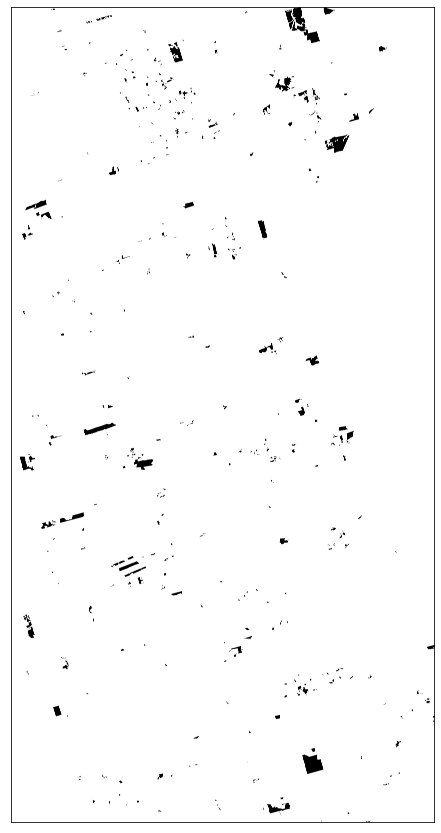

In [75]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [76]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9453222,)


(9453222,)

In [77]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [78]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.495893, F-Score=0.794


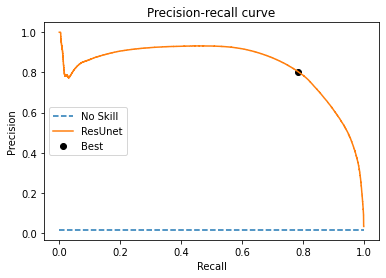

In [79]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [80]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = best_threshold
# threshold = 0.46
# threshold = 0.57
# threshold = 0.5624
# threshold = 0.43
# threshold = 0.33
# threshold = 0.41
# threshold = 0.414413
# threshold = 0.507776
# threshold = 0.5622921
# threshold = 0.516014
# threshold = 0.405565
# threshold = 0.348671
# threshold = 0.394683
# threshold = 0.541279
# threshold = 0.420339

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161517410,   1598590], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [81]:
threshold

0.5

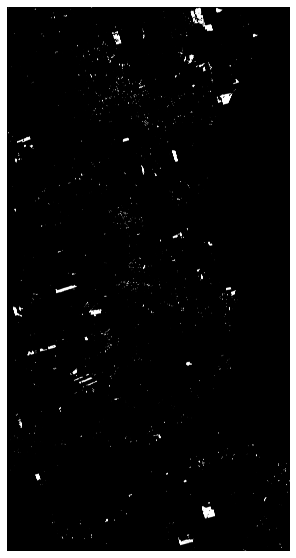

In [82]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [83]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [84]:
# mean_prob_unpad.shape

In [85]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [86]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [87]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [88]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [89]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [90]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54253101,)


(54253101,)

In [91]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161517410,   1598590], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161747823,   1368177], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162885587,    230413], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53407445,   736490, 27414065], dtype=int64))
ic| predicted_masked.shape: (54143935,)
    label_masked.shape: (54143935,)


In [92]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [93]:
# ic(f1, precision, recall, mAP)
ic(f1, precision, recall)


ic| f1: 80.83, precision: 93.26, recall: 71.33


(80.83, 93.26, 71.33)

### Metrics for validation set in forest/deforestation detection

In [94]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [95]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [96]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 81.11
    precision_val: 87.22
    recall_val: 75.8
    mAP_val: 83.3


(81.11, 87.22, 75.8, 83.3)

In [97]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [98]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162396605,    719395], dtype=int64))


In [99]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   596642, 162396605,    122753], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   596642, 162396605,    122753], dtype=int64))

In [100]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [101]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

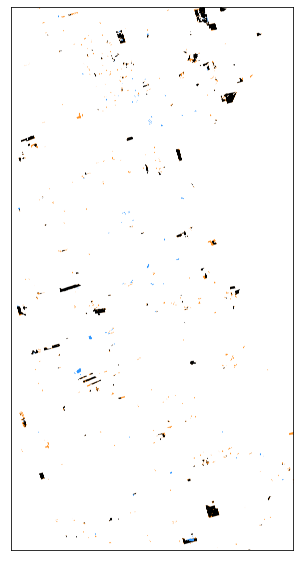

In [102]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


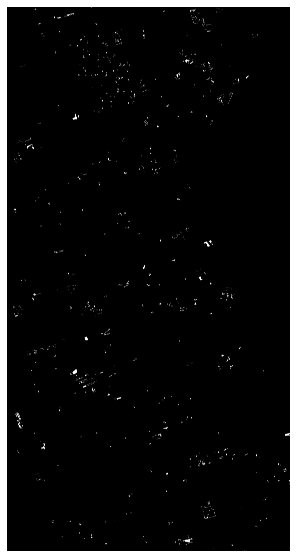

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [104]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54143935,)


(54143935,)

In [105]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [106]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [107]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [108]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


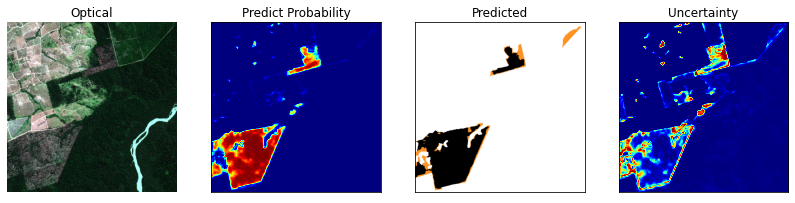

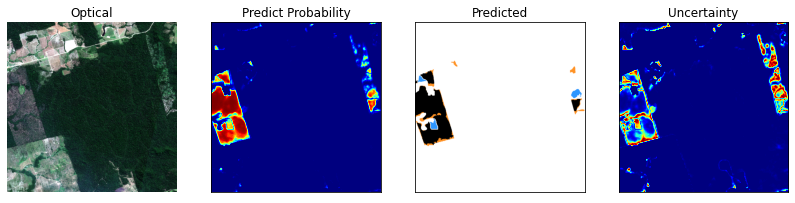

In [109]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [110]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    y_pred = pred_var_test
    y_pred_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    y_pred = MI_test
    y_pred_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    y_pred = pred_entropy_test
    y_pred_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    y_pred = pred_entropy_single_test
    y_pred_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [111]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(y_pred): 2.7304077e-19
    np.mean(y_pred): 0.01382655
    np.max(y_pred): 0.36787948
ic| np.min(pred_entropy): 4.1009997e-27
    np.mean(pred_entropy): 0.01212915
    np.max(pred_entropy): 0.36787948


(4.1009997e-27, 0.01212915, 0.36787948)

In [112]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, y_pred.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54143935,), y_pred.shape: (54143935,)
ic| roc_auc: 0.9573715746891196


0.9573715746891196

Best Threshold=0.082472, G-Mean=0.909


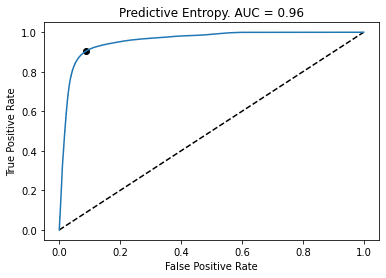

In [113]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [114]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.08247171


In [115]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [116]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(y_pred)
y_pred_thresholded[y_pred >= best_threshold_uncertainty] = 1


In [117]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [118]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [119]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [120]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [121]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [122]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [123]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [124]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, y_pred_val, pos_label=pos_label)



In [125]:
ic(thresholds)

ic| thresholds: array([0.0000636 , 0.0000636 , 0.0000636 , ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.0000636 , 0.0000636 , 0.0000636 , ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [126]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.277230, F-Score=0.309


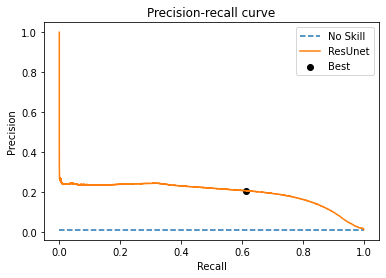

In [127]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [128]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [129]:
ic(np.min(y_pred), np.average(y_pred), np.max(y_pred))

ic| np.min(y_pred): 2.7304077e-19
    np.average(y_pred): 0.01382655
    np.max(y_pred): 0.36787948


(2.7304077e-19, 0.01382655, 0.36787948)

(array([50358161.,  1175178.,   574827.,   385917.,   296096.,   244597.,
          216200.,   204907.,   211137.,   476915.]),
 array([0.        , 0.03678795, 0.0735759 , 0.11036384, 0.1471518 ,
        0.18393974, 0.22072768, 0.25751564, 0.2943036 , 0.33109152,
        0.36787948], dtype=float32),
 <BarContainer object of 10 artists>)

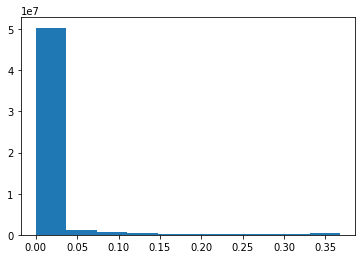

In [130]:
plt.hist(y_pred)

In [131]:
ic(y_pred.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| y_pred.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [132]:
ic(y_pred.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| y_pred.shape: (54143935,)
    label_mask_current_deforestation_test.shape: (54143935,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [133]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): 2.7304077e-19
    np.mean(y_pred): 0.01382655
    np.max(y_pred): 0.36787948


(2.7304077e-19, 0.01382655, 0.36787948)

In [134]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54143935,)


(54143935,)

In [135]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52519672,  1624263], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100783195,   1774752,  60558053], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52519672,  1624263], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100783195,   1774752,  60558053], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [136]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.02999898326562338


0.02999898326562338

In [137]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(y_pred, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.02999898326562338


0.02999898326562338

In [138]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(y_pred)-0.003]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metrics_values)


ic| y_pred.shape: (54143935,)
    label_mask_current_deforestation_test.shape: (54143935,)


threshold 0.005
(41890744,) (41890744,)


ic| label_current_deforestation_test_classified_incorrect.shape: (12253191,)
    predicted_test_classified_incorrect.shape: (12253191,)


cm_correct [[41815317        0]
 [    5550    69877]]


ic| TP_H + FN_H + FP_H + TN_H: 12253191
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 12253191
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[11554158    37970]
 [  205624   455439]]
[1.         0.92641892 0.09487841 0.22630773 0.92304559 0.68894946]
threshold 0.0075
(44548500,) (44548500,)


ic| label_current_deforestation_test_classified_incorrect.shape: (9595435,)
    predicted_test_classified_incorrect.shape: (9595435,)


cm_correct [[44444430        0]
 [    7820    96250]]


ic| TP_H + FN_H + FP_H + TN_H: 9595435
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 9595435
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[8925045   37970]
 [ 203354  429066]]
[1.         0.92485827 0.13068745 0.17722087 0.91870006 0.67845103]
threshold 0.01
(46177547,) (46177547,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7966388,)
    predicted_test_classified_incorrect.shape: (7966388,)


cm_correct [[46049847        0]
 [    9865   117835]]


ic| TP_H + FN_H + FP_H + TN_H: 7966388
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 7966388
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[7319628   37970]
 [ 201309  407481]]
[1.         0.92274863 0.15999538 0.14713352 0.91476055 0.66932933]
threshold 0.015
(47965231,) (47965231,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6178704,)
    predicted_test_classified_incorrect.shape: (6178704,)


cm_correct [[47802424        0]
 [   13101   149706]]


ic| TP_H + FN_H + FP_H + TN_H: 6178704
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 6178704
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[5567051   37970]
 [ 198073  375610]]
[1.         0.91953049 0.20326956 0.11411627 0.90819189 0.65473441]
threshold 0.025
(49517130,) (49517130,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4626805,)
    predicted_test_classified_incorrect.shape: (4626805,)


cm_correct [[49308233       81]
 [   17486   191330]]


ic| TP_H + FN_H + FP_H + TN_H: 4626805
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 4626805
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[4061242   37889]
 [ 193688  333986]]
[0.99957683 0.91626121 0.25978628 0.0854538  0.89811361 0.63294003]
threshold 0.05
(50917048,) (50917048,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3226887,)
    predicted_test_classified_incorrect.shape: (3226887,)


cm_correct [[50640437      271]
 [   25544   250796]]


ic| TP_H + FN_H + FP_H + TN_H: 3226887
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 3226887
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[2729038   37699]
 [ 185630  274520]]
[0.99892061 0.90756315 0.34052872 0.05959831 0.87925463 0.59658807]
threshold 0.08
(51656067,) (51656067,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2487868,)
    predicted_test_classified_incorrect.shape: (2487868,)


cm_correct [[51328300      452]
 [   31996   295319]]


ic| TP_H + FN_H + FP_H + TN_H: 2487868
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 2487868
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[2041175   37518]
 [ 179178  229997]]
[0.99847179 0.90224707 0.40098168 0.04594915 0.85975366 0.56209935]
threshold 0.1
(51972176,) (51972176,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2171759,)
    predicted_test_classified_incorrect.shape: (2171759,)


cm_correct [[51616428      672]
 [   35950   319126]]


ic| TP_H + FN_H + FP_H + TN_H: 2171759
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 2171759
    len(label_mask_current_deforestation_test): 54143935


cm_incorrect [[1753047   37298]
 [ 175224  206190]]
[0.99789867 0.89875407 0.43330663 0.04011085 0.84681791 0.54059369]
threshold 0.15
(52519672,) (52519672,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624263,)
    predicted_test_classified_incorrect.shape: (1624263,)
ic

cm_correct [[52100135     1701]
 [   46627   371209]]
cm_incorrect [[1269340   36269]
 [ 164547  154107]]


| TP_H + FN_H + FP_H + TN_H: 1624263
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 1624263
    len(label_mask_current_deforestation_test): 54143935


[0.99543858 0.88840837 0.50402449 0.02999898 0.80948754 0.4836186 ]
threshold 0.2
(52901901,) (52901901,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1242034,)
    predicted_test_classified_incorrect.shape: (1242034,)
ic| TP_H + FN_H + FP_H + TN_H: 1242034
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 1242034
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[52422593     3775]
 [   58490   417043]]
cm_incorrect [[946882  34195]
 [152684 108273]]
[0.99102938 0.87700118 0.56625752 0.02293949 0.75998119 0.41490744]
threshold 0.25
(53208300,) (53208300,)


ic| label_current_deforestation_test_classified_incorrect.shape: (935635,)
    predicted_test_classified_incorrect.shape: (935635,)
ic| TP_H + FN_H + FP_H + TN_H: 935635
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 935635
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[52668916     9602]
 [   72144   457638]]
cm_incorrect [[700559  28368]
 [139030  67678]]
[0.97944953 0.86382323 0.62137707 0.01728051 0.70464153 0.32740871]
threshold 0.27
(53321103,) (53321103,)


ic| label_current_deforestation_test_classified_incorrect.shape: (822832,)
    predicted_test_classified_incorrect.shape: (822832,)
ic| TP_H + FN_H + FP_H + TN_H: 822832
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 822832
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[52756629    13472]
 [   78484   472518]]
cm_incorrect [[612846  24498]
 [132690  52798]]
[0.97227927 0.85756132 0.64158101 0.01519712 0.68306251 0.28464375]
threshold 0.3
(53487920,) (53487920,)


ic| label_current_deforestation_test_classified_incorrect.shape: (656015,)
    predicted_test_classified_incorrect.shape: (656015,)
ic| TP_H + FN_H + FP_H + TN_H: 656015
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 656015
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[52882803    21407]
 [   90342   493368]]
cm_incorrect [[486672  16563]
 [120832  31948]]
[0.95841484 0.84522794 0.66989097 0.01211613 0.65857228 0.20911114]
threshold 0.34
(53722507,) (53722507,)


ic| label_current_deforestation_test_classified_incorrect.shape: (421428,)
    predicted_test_classified_incorrect.shape: (421428,)
ic| TP_H + FN_H + FP_H + TN_H: 421428
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 421428
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[53053329    35548]
 [  113333   520297]]
cm_incorrect [[316146   2422]
 [ 97841   5019]]
[0.93604692 0.82113694 0.70645494 0.00778348 0.67450611 0.04879448]
threshold 0.36
(53917928,) (53917928,)


ic| label_current_deforestation_test_classified_incorrect.shape: (226007,)
    predicted_test_classified_incorrect.shape: (226007,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 226007
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 226007
    len(label_mask_current_deforestation_test): 54143935


cm_correct [[53199642    37970]
 [  155000   525316]]
cm_incorrect [[169833      0]
 [ 56174      0]]
[0.93259197 0.7721647  0.7132697  0.00417419        nan 0.        ]
threshold 0.3648794801235199
(54005203,) (54005203,)


ic| label_current_deforestation_test_classified_incorrect.shape: (138732,)
    predicted_test_classified_incorrect.shape: (138732,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 138732
    len(label_mask_current_deforestation_test): 54143935
ic| TP_H + FN_H + FP_H + TN_H: 138732
    len(label_mask_current_deforestation_test): 54143935
ic| metrics_values: array([[1.        , 0.92641892, 0.09487841, 0.22630773, 0.92304559,
                            0.68894946],
                           [1.        , 0.92485827, 0.13068745, 0.17722087, 0.91870006,
                            0.67845103],
                           [1.        , 0.92274863, 0.15999538, 0.14713352, 0.91476055,
                            0.66932933],
                           [1.        , 0.91953049, 0.20326956, 0.11411627, 0.90819189,
                            0.65473441],
        

cm_correct [[53265488    37970]
 [  176429   525316]]
cm_incorrect [[103987      0]
 [ 34745      0]]
[0.93259197 0.74858531 0.7132697  0.00256228        nan 0.        ]


In [139]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| y_pred.shape: (54143935,)
    label_mask_current_deforestation_test.shape: (54143935,)


threshold 0.005
(54143935,) (54143935,)
cm_audited [[53407445        0]
 [    5550   730940]]
[1.         0.99246426]
threshold 0.0075
(54143935,) (54143935,)
cm_audited [[53407445        0]
 [    7820   728670]]
[1.         0.98938207]
threshold 0.01
(54143935,) (54143935,)
cm_audited [[53407445        0]
 [    9865   726625]]
[1.         0.98660539]
threshold 0.015
(54143935,) (54143935,)
cm_audited [[53407445        0]
 [   13101   723389]]
[1.         0.98221157]
threshold 0.025
(54143935,) (54143935,)
cm_audited [[53407364       81]
 [   17486   719004]]
[0.99988736 0.97625765]
threshold 0.05
(54143935,) (54143935,)
cm_audited [[53407174      271]
 [   25544   710946]]
[0.99961896 0.96531657]
threshold 0.08
(54143935,) (54143935,)
cm_audited [[53406993      452]
 [   31996   704494]]
[0.99935882 0.9565561 ]
threshold 0.1
(54143935,) (54143935,)
cm_audited [[53406773      672]
 [   35950   700540]]
[0.99904166 0.95118739]
threshold 0.15
(54143935,) (54143935,)
cm_audited [[53405744

ic| metric_values_audited: array([[1.        , 0.99246426],
                                  [1.        , 0.98938207],
                                  [1.        , 0.98660539],
                                  [1.        , 0.98221157],
                                  [0.99988736, 0.97625765],
                                  [0.99961896, 0.96531657],
                                  [0.99935882, 0.9565561 ],
                                  [0.99904166, 0.95118739],
                                  [0.99754036, 0.93669025],
                                  [0.99446298, 0.92058276],
                                  [0.98575261, 0.90204348],
                                  [0.9799368 , 0.89343508],
                                  [0.96793223, 0.87733438],
                                  [0.94603351, 0.84611739],
                                  [0.93870468, 0.78954229],
                                  [0.93650831, 0.76044617]])


cm_audited [[53369475    37970]
 [  176429   560061]]
[0.93650831 0.76044617]


In [140]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [141]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(y_pred,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(y_pred,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [142]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [143]:
save_figures = True

In [144]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}



In [145]:
#  threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [146]:
# m['precision_H'] = np.nan_to_num(m['precision_H'], nan=0)

In [147]:
'''
m = {'precision_L': metrics[1:,0],
        'recall_L': metrics[1:,1],
        'recall_Ltotal': metrics[1:,2],
        'AA': metrics[1:,3],
        'precision_H': metrics[1:,4],
        'recall_H': metrics[1:,5]}

threshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
'''

"\nm = {'precision_L': metrics[1:,0],\n        'recall_L': metrics[1:,1],\n        'recall_Ltotal': metrics[1:,2],\n        'AA': metrics[1:,3],\n        'precision_H': metrics[1:,4],\n        'recall_H': metrics[1:,5]}\n\nthreshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\n"

In [148]:
'''
plt.plot(m['recall_L']*100, m['AA']*100)
plt.title('Recall vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, m['AA']*100)\nplt.title('Recall vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')\n"

In [149]:
'''
plt.plot(m['precision_L']*100, m['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, m['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')\n"

In [150]:
'''
plt.plot(m['recall_Ltotal']*100, m['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, m['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')\n"

In [151]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Recall vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Recall vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [152]:
'''
plt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [153]:
'''
plt.plot(m['precision_L']*100, np.asarray(threshold_list))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, np.asarray(threshold_list))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [154]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Audit area vs. Threshold')
plt.xlabel('Audit area (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Audit area vs. Threshold')\nplt.xlabel('Audit area (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [155]:
m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

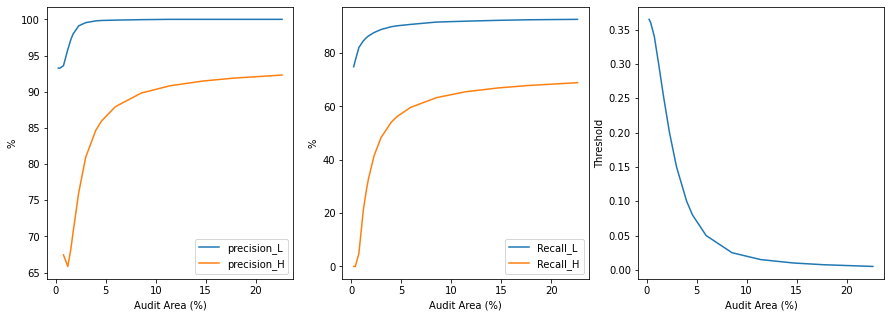

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [157]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


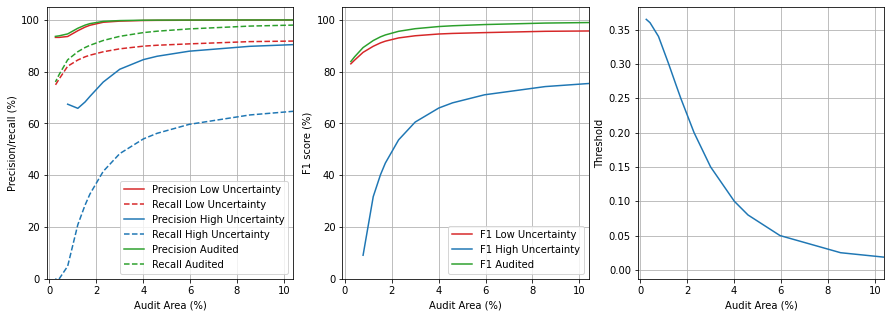

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [159]:


m

{'precision_L': array([1.        , 1.        , 1.        , 1.        , 0.99957683,
        0.99892061, 0.99847179, 0.99789867, 0.99543858, 0.99102938,
        0.97944953, 0.97227927, 0.95841484, 0.93604692, 0.93259197,
        0.93259197]),
 'recall_L': array([0.92641892, 0.92485827, 0.92274863, 0.91953049, 0.91626121,
        0.90756315, 0.90224707, 0.89875407, 0.88840837, 0.87700118,
        0.86382323, 0.85756132, 0.84522794, 0.82113694, 0.7721647 ,
        0.74858531]),
 'recall_Ltotal': array([0.09487841, 0.13068745, 0.15999538, 0.20326956, 0.25978628,
        0.34052872, 0.40098168, 0.43330663, 0.50402449, 0.56625752,
        0.62137707, 0.64158101, 0.66989097, 0.70645494, 0.7132697 ,
        0.7132697 ]),
 'AA': array([0.22630773, 0.17722087, 0.14713352, 0.11411627, 0.0854538 ,
        0.05959831, 0.04594915, 0.04011085, 0.02999898, 0.02293949,
        0.01728051, 0.01519712, 0.01211613, 0.00778348, 0.00417419,
        0.00256228]),
 'precision_H': array([0.92304559, 0.91870006,

In [160]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 1.        , 0.99988736,
        0.99961896, 0.99935882, 0.99904166, 0.99754036, 0.99446298,
        0.98575261, 0.9799368 , 0.96793223, 0.94603351, 0.93870468,
        0.93650831]),
 'recall': array([0.99246426, 0.98938207, 0.98660539, 0.98221157, 0.97625765,
        0.96531657, 0.9565561 , 0.95118739, 0.93669025, 0.92058276,
        0.90204348, 0.89343508, 0.87733438, 0.84611739, 0.78954229,
        0.76044617]),
 'f1': array([0.99621788, 0.9946627 , 0.99325754, 0.99102597, 0.98793123,
        0.98216835, 0.97748912, 0.97452741, 0.96615814, 0.95609777,
        0.94204212, 0.93468886, 0.92040925, 0.89329019, 0.85768649,
        0.83934385])}

In [161]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([157084839,   6031161], dtype=int64))


(array([0, 1], dtype=int8), array([157084839,   6031161], dtype=int64))

(-0.5, 9215.5, 17759.5, -0.5)

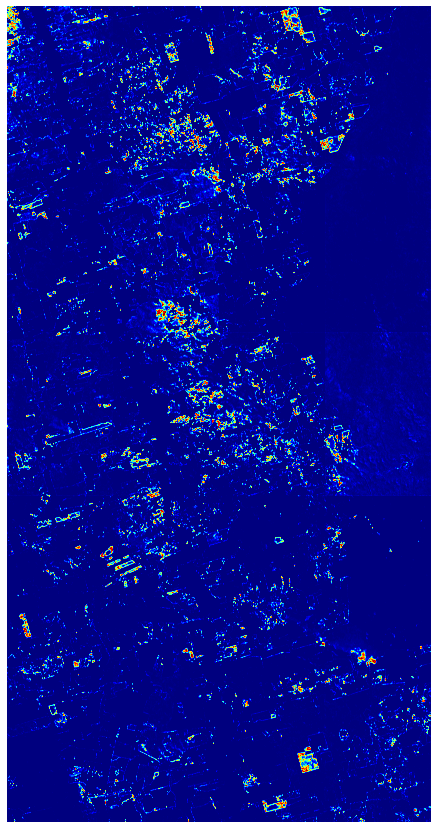

In [162]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

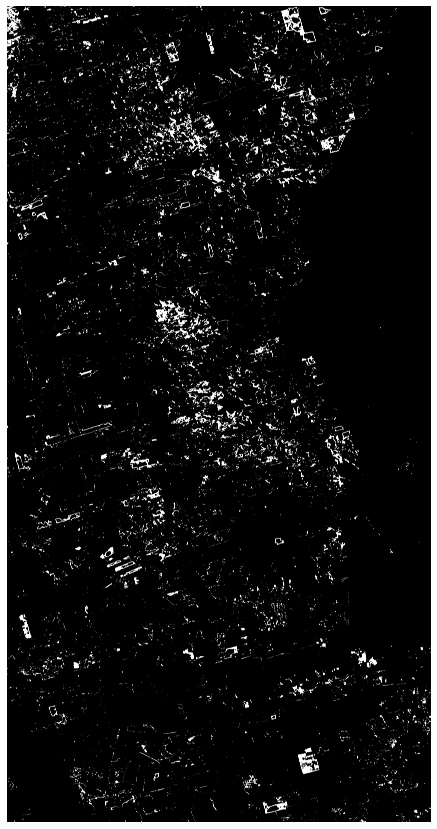

In [163]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [164]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9182054,  271168], dtype=int64))

In [165]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(y_pred_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(y_pred_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| y_pred_val.shape: (9453222,)
    label_mask_val_valid.shape: (9453222,)


threshold 0.015
(7038793,) (7038793,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2414429,)
    predicted_test_classified_incorrect.shape: (2414429,)


cm_correct [[7018777    3273]
 [    311   16432]]


ic| TP_H + FN_H + FP_H + TN_H: 2414429
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 2414429
    len(label_mask_current_deforestation_test): 9453222


cm_incorrect [[2133162   26842]
 [  65324  189101]]
[0.83390003 0.98142507 0.06059712 0.25540805 0.87569868 0.7432485 ]
threshold 0.025
(7573944,) (7573944,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1879278,)
    predicted_test_classified_incorrect.shape: (1879278,)


cm_correct [[7544055    4097]
 [    702   25090]]


ic| TP_H + FN_H + FP_H + TN_H: 1879278
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 1879278
    len(label_mask_current_deforestation_test): 9453222


cm_incorrect [[1607884   26018]
 [  64933  180443]]
[0.85962929 0.97278226 0.09252567 0.19879762 0.87398104 0.73537347]
threshold 0.05
(8196747,) (8196747,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1256475,)
    predicted_test_classified_incorrect.shape: (1256475,)
ic| TP_H + FN_H + FP_H + TN_H: 1256475
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 1256475
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8143434    5204]
 [   1684   46425]]
cm_incorrect [[1008505   24911]
 [  63951  159108]]
[0.89920394 0.96499615 0.17120383 0.132915   0.86462811 0.71330007]
threshold 0.08
(8533253,) (8533253,)


ic| label_current_deforestation_test_classified_incorrect.shape: (919969,)
    predicted_test_classified_incorrect.shape: (919969,)
ic| TP_H + FN_H + FP_H + TN_H: 919969
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 919969
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8450425    6174]
 [   2842   73812]]
cm_incorrect [[701514  23941]
 [ 62793 131721]]
[0.92281149 0.96292431 0.27220026 0.09731804 0.84619882 0.67718005]
threshold 0.1
(8665549,) (8665549,)


ic| label_current_deforestation_test_classified_incorrect.shape: (787673,)
    predicted_test_classified_incorrect.shape: (787673,)
ic| TP_H + FN_H + FP_H + TN_H: 787673
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 787673
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8565425    6783]
 [   3754   89587]]
cm_incorrect [[586514  23332]
 [ 61881 115946]]
[0.92961503 0.95978188 0.33037453 0.08332323 0.83247893 0.65201572]
threshold 0.15
(8869439,) (8869439,)


ic| label_current_deforestation_test_classified_incorrect.shape: (583783,)
    predicted_test_classified_incorrect.shape: (583783,)
ic| TP_H + FN_H + FP_H + TN_H: 583783
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 583783
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8734852    8105]
 [   6511  119971]]
cm_incorrect [[417087  22010]
 [ 59124  85562]]
[0.93671726 0.94852232 0.44242315 0.06175492 0.79539285 0.59136337]
threshold 0.2
(9002851,) (9002851,)


ic| label_current_deforestation_test_classified_incorrect.shape: (450371,)
    predicted_test_classified_incorrect.shape: (450371,)
ic| TP_H + FN_H + FP_H + TN_H: 450371
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 450371
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8836994   10035]
 [  10226  145596]]
cm_incorrect [[314945  20080]
 [ 55409  59937]]
[0.93552056 0.93437384 0.53692176 0.04764206 0.74905333 0.5196279 ]
threshold 0.25
(9112932,) (9112932,)


ic| label_current_deforestation_test_classified_incorrect.shape: (340290,)
    predicted_test_classified_incorrect.shape: (340290,)
ic| TP_H + FN_H + FP_H + TN_H: 340290
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 340290
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8915838   14405]
 [  15156  167533]]
cm_incorrect [[236101  15710]
 [ 50479  38000]]
[0.92082468 0.91703934 0.61781995 0.03599725 0.70750326 0.42948044]
threshold 0.27
(9154272,) (9154272,)


ic| label_current_deforestation_test_classified_incorrect.shape: (298950,)
    predicted_test_classified_incorrect.shape: (298950,)
ic| TP_H + FN_H + FP_H + TN_H: 298950
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 298950
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8943489   17100]
 [  17792  175891]]
cm_incorrect [[208450  13015]
 [ 47843  29642]]
[0.91139483 0.90813856 0.64864217 0.03162414 0.69489181 0.38255146]
threshold 0.3
(9215802,) (9215802,)


ic| label_current_deforestation_test_classified_incorrect.shape: (237420,)
    predicted_test_classified_incorrect.shape: (237420,)
ic| TP_H + FN_H + FP_H + TN_H: 237420
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 237420
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8983218   21928]
 [  22686  187970]]
cm_incorrect [[168721   8187]
 [ 42949  17563]]
[0.89553021 0.89230784 0.69318651 0.02511525 0.68205825 0.29023995]
threshold 0.34
(9307297,) (9307297,)


ic| label_current_deforestation_test_classified_incorrect.shape: (145925,)
    predicted_test_classified_incorrect.shape: (145925,)
ic| TP_H + FN_H + FP_H + TN_H: 145925
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 145925
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9042998   28912]
 [  32325  203062]]
cm_incorrect [[108941   1203]
 [ 33310   2471]]
[0.87536534 0.86267296 0.74884205 0.01543654 0.67256396 0.069059  ]
threshold 0.36
(9375974,) (9375974,)


ic| label_current_deforestation_test_classified_incorrect.shape: (77248,)
    predicted_test_classified_incorrect.shape: (77248,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 77248
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 77248
    len(label_mask_current_deforestation_test): 9453222
ic| metrics_values_val: array([[0.83390003, 0.98142507, 0.06059712, 0.25540805, 0.87569868,
                                0.7432485 ],
                               [0.85962929, 0.97278226, 0.09252567, 0.19879762, 0.87398104,
                                0.73537347],
                               [0.89920394, 0.96499615, 0.17120383, 0.132915  , 0.86462811,
                                0.71330007],
                               [0.92281149, 0.96292431, 0.27220026, 0.09731804, 0.84619882,
                           

cm_correct [[9093079   30115]
 [  47247  205533]]
cm_incorrect [[58860     0]
 [18388     0]]
[0.87220346 0.81309043 0.75795448 0.00817161        nan 0.        ]


In [166]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [167]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


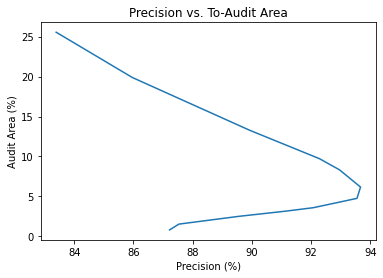

In [168]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

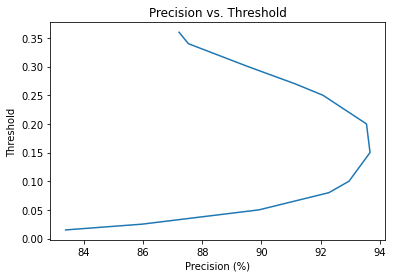

In [169]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

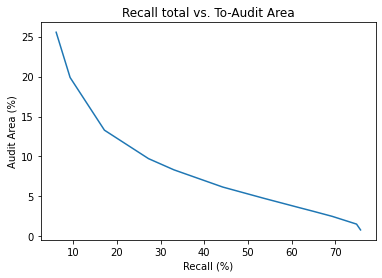

In [170]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

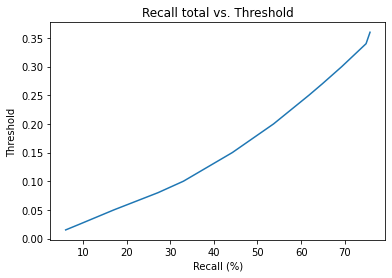

In [171]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

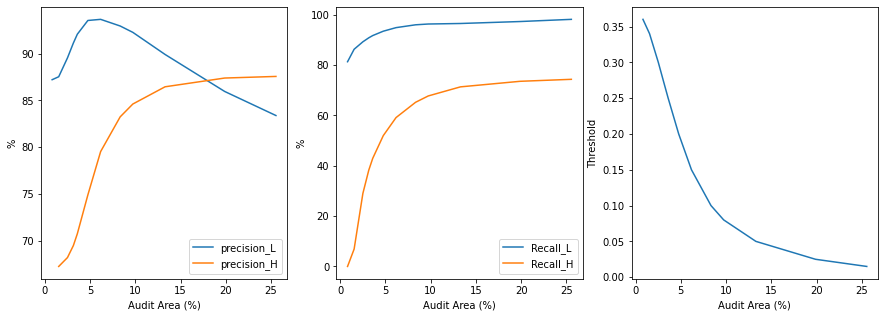

In [172]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

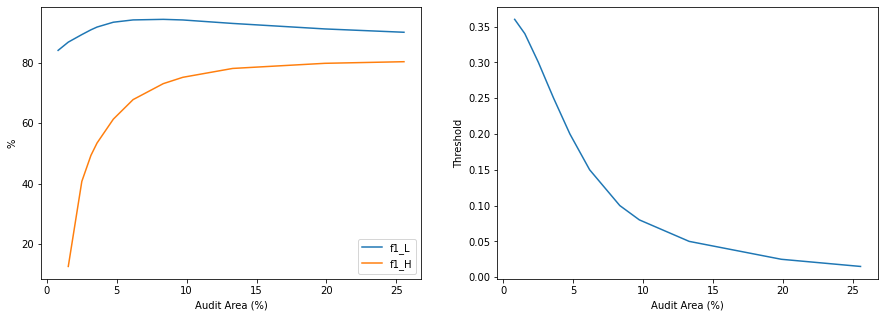

In [173]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

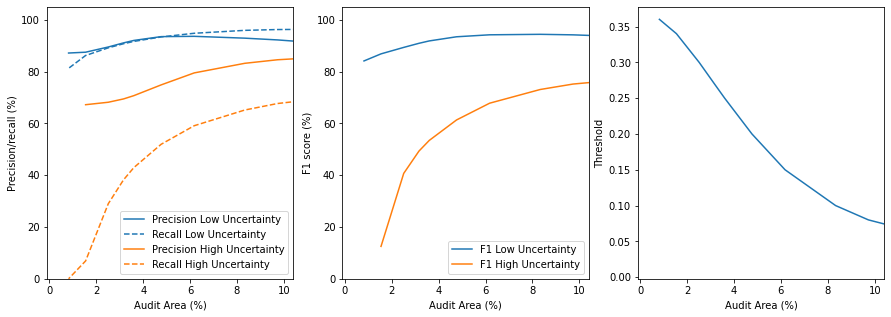

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')